## Config

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
from competitions import planet as comp

/home/bfortuner/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
TRAIN_PATH = cfg.PATHS['datasets']['inputs']['trn_jpg'] 
TEST_PATH = cfg.PATHS['datasets']['inputs']['tst_jpg']
metadata_df = metadata.get_metadata_df(
    cfg.METADATA_PATH)

In [3]:
HARDWARE_CONFIG = {
    'hostname': socket.gethostname(),
    'random_seed': 3,
    'gpu_device':0
}
torch.cuda.set_device(HARDWARE_CONFIG['gpu_device'])
cudnn.benchmark = True

DATA_CONFIG = {
    'img_rescale': 256,
    'dset_fold': 'fold5K',
    'n_classes': len(comp.LABEL_NAMES)
}

TRAIN_CONFIG = {
    'initial_lr': 2e-1,
    'weight_decay': 2e-5,
    'n_epochs': 60,
    'n_cycles': 12,
    'early_stop_metric': metric.F2Score().name,
    'max_patience': 20,
    'batch_size': 64,
    'threshold': 0.2,
    'save_weights_cadence': 1,
}
OTHER_CONFIG = {}

TRANSFORMS = {
    c.TRAIN: torchsample.transforms.Compose([
        transforms.Scale(DATA_CONFIG['img_rescale']),
        transforms.RandomHorizontalFlip(),
        data_aug.RandomRotate90(p=0.75),
        transforms.ToTensor(),
        torchsample.transforms.RandomFlip(h=False,v=True,p=0.5),
        data_aug.IMAGENET_NORMALIZE
    ]),
    c.VAL: torchsample.transforms.Compose([
        transforms.Scale(DATA_CONFIG['img_rescale']),
        transforms.ToTensor(),
        data_aug.IMAGENET_NORMALIZE
    ]),
    c.TEST: torchsample.transforms.Compose([
        transforms.Scale(DATA_CONFIG['img_rescale']),
        transforms.ToTensor(),
        data_aug.IMAGENET_NORMALIZE
    ])
}

## Data

In [4]:
# Make new fold (if not exists)
fpaths,fnames = utils.files.get_paths_to_files(TRAIN_PATH)
print(len(fpaths))
val_size = math.floor(len(fnames)*.13)
fold = data_folds.make_fold(DATA_CONFIG['dset_fold'], TRAIN_PATH, TEST_PATH, 
                             cfg.PATHS['folds'], val_size, shuffle=True)
print("total", len(fpaths), "val",len(fold['val']), 'trn',len(fold['trn']))

40479
val 5262 trn 35217


In [5]:
SAMPLE = 1000000
fold = data_folds.load_data_fold(cfg.PATHS['folds'], DATA_CONFIG['dset_fold'])
trn_fpaths = data_folds.get_fpaths_from_fold(fold, c.TRAIN, TRAIN_PATH,
                                             postfix=c.INPUT_POSTFIX)[:SAMPLE]
val_fpaths = data_folds.get_fpaths_from_fold(fold, c.VAL, TRAIN_PATH,
                                             postfix=c.INPUT_POSTFIX)
tst_fpaths = data_folds.get_fpaths_from_fold(fold, c.TEST, TEST_PATH, postfix=c.JPG_EXT)

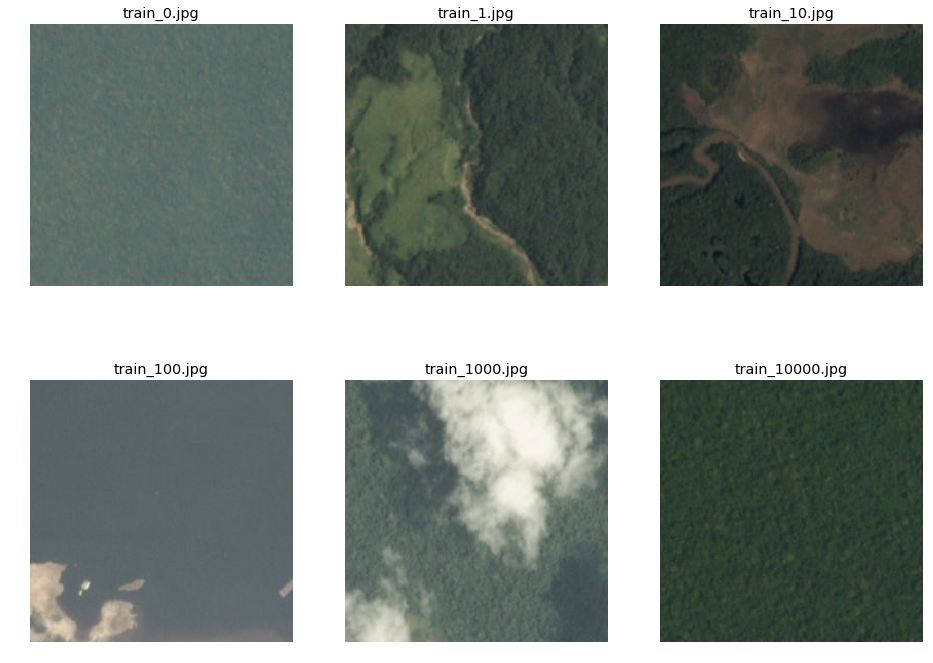

In [6]:
utils.imgs.plot_samples_from_dir(TRAIN_PATH)

In [7]:
# Slow
trn_targs = metadata.get_one_hots_from_fold(
    cfg.METADATA_PATH, fold, c.TRAIN, comp.LABEL_NAMES)[:SAMPLE]
val_targs = metadata.get_one_hots_from_fold(
    cfg.METADATA_PATH, fold, c.VAL, comp.LABEL_NAMES)

In [8]:
img_reader = 'pil'
trn_dataset = datasets.datasets.FileDataset(
    trn_fpaths, img_reader, trn_targs, TRANSFORMS[c.TRAIN])
val_dataset = datasets.datasets.FileDataset(
    val_fpaths, img_reader, val_targs, TRANSFORMS[c.VAL])
tst_dataset = datasets.datasets.FileDataset(
    tst_fpaths, img_reader, None, TRANSFORMS[c.TEST])
print("trn",len(trn_dataset),"val",len(val_dataset))

trn_loader = data_loaders.get_data_loader(trn_dataset, TRAIN_CONFIG['batch_size'], 
                                          shuffle=True, n_workers=4, pin_memory=True)
val_loader = data_loaders.get_data_loader(val_dataset, TRAIN_CONFIG['batch_size'],
                                          shuffle=False, n_workers=4, pin_memory=True)
tst_loader = data_loaders.get_data_loader(tst_dataset, TRAIN_CONFIG['batch_size'],
                                          shuffle=False, n_workers=2, pin_memory=False)

trn 35217 val 5262


In [9]:
inputs,targets,img_paths = next(iter(trn_loader))
inputs.size(),targets.size(),img_paths[:3]

(torch.Size([64, 3, 256, 256]),
 torch.Size([64, 17]),
 ['/bigguy/data/planet/datasets/inputs/trn_jpg/train_5149.jpg',
  '/bigguy/data/planet/datasets/inputs/trn_jpg/train_5849.jpg',
  '/bigguy/data/planet/datasets/inputs/trn_jpg/train_37662.jpg'])

## Train

In [60]:
# Initialize model
resnet = models.resnet.get_resnet34(pretrained=True, n_freeze=0)
resnet = models.builder.cut_model(resnet, 7)
classifier = models.builder.get_mlp_classifier(in_feat=512, out_feat=512, 
                                               n_classes=DATA_CONFIG['n_classes'], 
                                               activation=nn.Sigmoid())
model = models.resnet.ConcatResnet(resnet, classifier)
model = model.cuda()
# outputs = model(Variable(inputs))
# print(outputs.size(), targets.size())

In [ ]:
# Load existing weights (optional)
experiment_name = ''
epoch = None
exp_utils.load_weights_by_exp_and_epoch(model, experiment_name, epoch)

In [61]:
# Initialize trainer
criterion = F.binary_cross_entropy
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
                            lr=TRAIN_CONFIG['initial_lr'],  momentum=0.9, nesterov=False,
                            weight_decay=TRAIN_CONFIG['weight_decay'])

n_iters = TRAIN_CONFIG['n_epochs'] * len(trn_loader)
lr_adjuster = learning_rates.SnapshotLR(TRAIN_CONFIG['initial_lr'], 'mini_batch', 
                                        TRAIN_CONFIG['initial_lr'], n_iters,
                                        n_cycles=TRAIN_CONFIG['n_cycles'])
trainer = trainers.Trainer(criterion, criterion, optimizer, lr_adjuster)

In [62]:
# Experiment config
NEW_EXP_NAME = 'Baseline'
RESUME_EXP_NAME = None #'BaselineConcatResnet-SGD-SnapshotLR-img256-lr0.2-wd2e-05-bs64-fold5K-id83FA8'
if not RESUME_EXP_NAME:
    EXP_NAME_ARGS = [utils.general.get_class_name(model), 
                    utils.general.get_class_name(optimizer), 
                    utils.general.get_class_name(lr_adjuster),
                    'img'+str(DATA_CONFIG['img_rescale']),
                    'lr'+str(TRAIN_CONFIG['initial_lr']),
                    'wd'+str(TRAIN_CONFIG['weight_decay']),
                    'bs'+str(TRAIN_CONFIG['batch_size']),
                    str(DATA_CONFIG['dset_fold'])]
    EXPERIMENT_NAME = exp_utils.generate_display_name(NEW_EXP_NAME, EXP_NAME_ARGS)
    METRICS = [metric.Loss(), metric.Accuracy(), metric.F2Score()]
    AUX_METRICS = [metric.AuxiliaryMetric('LearningRate', 'lr'), 
                   metric.AuxiliaryMetric('SystemMemory', 'mb')]
    VISUALIZERS = [Viz(EXPERIMENT_NAME)]

    EXP_CONFIG = {
        'name': EXPERIMENT_NAME,
        'parent_dir': cfg.PATHS['experiments'],
        'metrics': METRICS,
        'aux_metrics': AUX_METRICS,
        'visualizers': VISUALIZERS,
        'data': DATA_CONFIG,
        'training': TRAIN_CONFIG,
        'other': OTHER_CONFIG,
        'transforms': TRANSFORMS[c.TRAIN],
        'hardware': HARDWARE_CONFIG,
        'model': model,
        'optimizer': optimizer,
        'lr_adjuster': lr_adjuster,
        'criterion': criterion
    }

In [22]:
# Resume experiment
exp = Experiment(RESUME_EXP_NAME, cfg.PATHS['experiments'])
exp.resume(verbose=False)
trainer = trainers.Trainer(criterion, criterion, exp.optim, lr_adjuster)

Resuming existing experiment


In [63]:
# Create new experiment
exp = Experiment(EXP_CONFIG['name'], cfg.PATHS['experiments'])
exp.init(EXP_CONFIG)
print(exp.name)

BaselineConcatResnet-SGD-SnapshotLR-img256-lr0.2-wd2e-05-bs64-fold5K-id1D5CB


In [ ]:
exp.train(trainer, trn_loader, val_loader)

## Predict

In [29]:
# Load model from exp epoch
exp.load_model_state(epoch=34)
model = exp.model

# OR load custom model weights
exp_name = RESUME_EXP_NAME
w_path = os.path.join(cfg.PATHS['experiments'], exp_name, 'weights', 'weights-34.th')
models.utils.load_weights(model, w_path)

In [33]:
%time val_probs = predictions.get_probabilities(model, val_loader)
pred_fpath = predictions.get_prediction_fpath(basename='my_exp', dset=c.VAL)
_ = predictions.save_or_append_pred_to_file(pred_fpath, val_probs)

/bigguy/data/planet/predictions/my_exp_val.bc


Acc 0.965736579695 F2 0.942264736154 BCE 0.06536467373371124


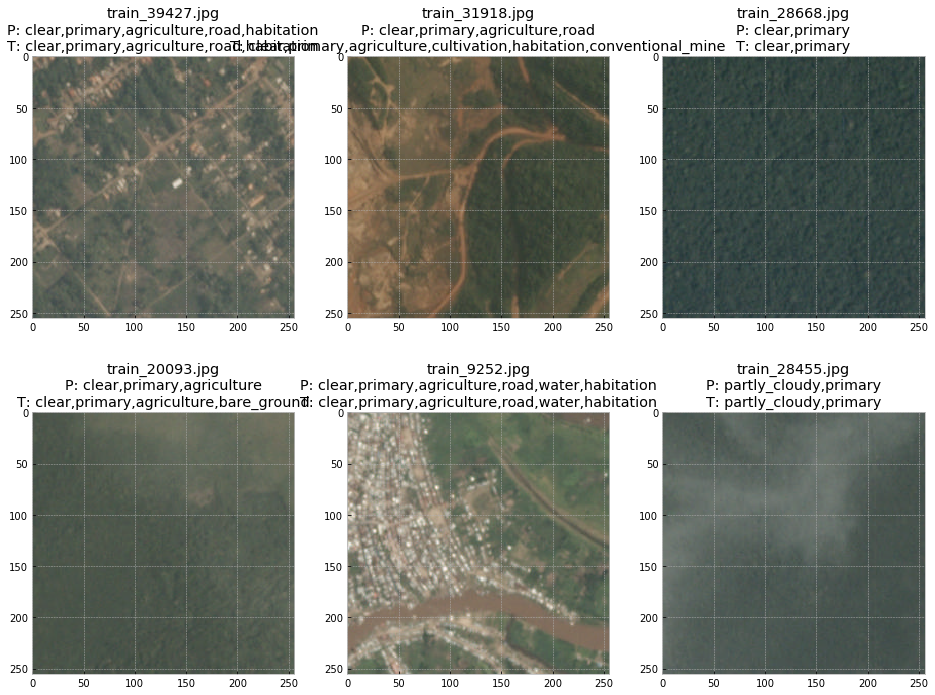

In [34]:
thresh = TRAIN_CONFIG['threshold']
acc = metric_utils.get_accuracy(val_probs > thresh, val_targs)
f2 = metric_utils.get_metric_in_blocks(val_probs > thresh, val_targs, 
                                       1000, metric_utils.get_f2_score)
loss = metric_utils.get_cross_entropy_loss(val_probs, val_targs)
print("Acc",acc,"F2",f2,"BCE",loss)
utils.imgs.plot_sample_preds(val_fpaths, val_probs > thresh, 
                             val_targs, comp.LABEL_NAMES)

In [35]:
%time tst_probs = predictions.get_probabilities(model, tst_loader)

CPU times: user 44.2 s, sys: 11.6 s, total: 55.8 s
Wall time: 56.7 s


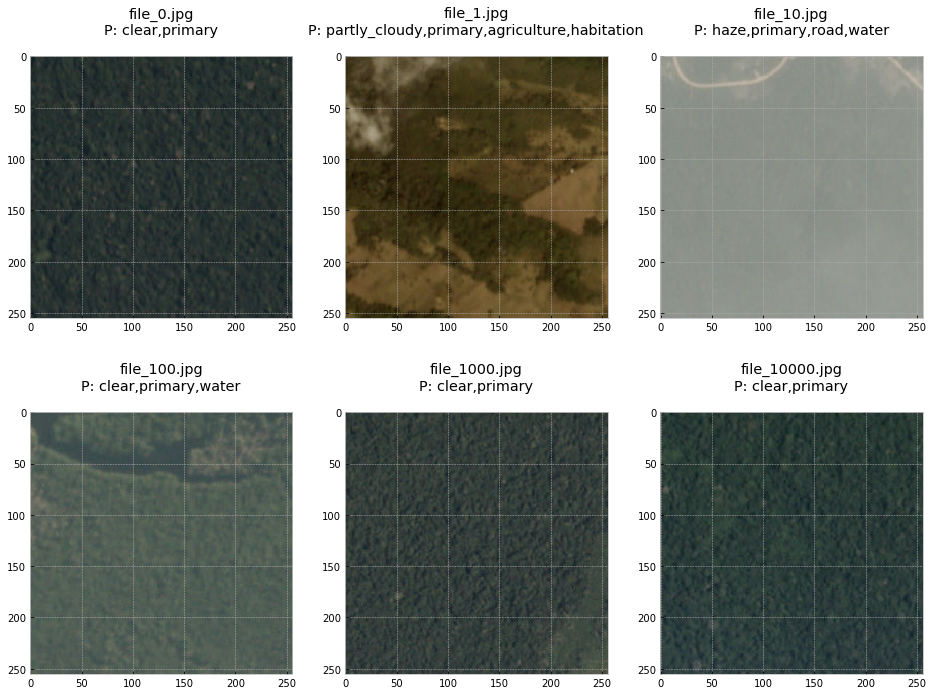

In [46]:
pred_fpath = predictions.get_prediction_fpath(basename='my_exp2', dset=c.TEST)
_ = predictions.save_or_append_pred_to_file(pred_fpath, tst_probs)
tst_preds = predictions.load_pred(pred_fpath, numpy=True)
utils.imgs.plot_sample_preds(tst_fpaths, tst_probs > thresh, 
                             None, comp.LABEL_NAMES)

## Ensemble

In [48]:
member_fpaths = predictions.list_local_preds(dset=c.TEST, fnames_only=False)
member_fpaths

['/bigguy/data/planet/predictions/my_exp_tst.bc',
 '/bigguy/data/planet/predictions/my_exp2_tst.bc']

In [49]:
ens_fpath = ensembles.get_ensemble_fpath(basename='my_exp', dset=c.TEST)
_ = ensembles.ens_prediction_files(
    ens_fpath, member_fpaths, block_size=1000, method=c.MEAN)
ens_probs = predictions.load_pred(ens_fpath, numpy=True)

/bigguy/data/planet/predictions/my_exp_ens_tst.bc
inputs 61191
Time 0.0m 0.06s


## Submit

In [21]:
sub_fpath = submissions.get_sub_path_from_pred_path(pred_fpath)
fnames = [f.split('.')[0] for f in utils.files.get_fnames_from_fpaths(tst_fpaths)]
submissions.make_tags_submission(sub_fpath, fnames, np.array(tst_probs) > thresh, 
                                 comp.LABEL_NAMES, comp.SUB_HEADER)

In [ ]:
# https://www.kaggle.com/c/planet-understanding-the-amazon-from-space - top 10%
# kg submit -m 'my sub' -c planet-understanding-the-amazon-from-space -v -u USERNAME -p PASSWORD planet_tst.csv
FileLink(sub_fpath)

## Evaluate

In [17]:
# Load Pred
fname = 'planet_val.bc'
thresh = TRAIN_CONFIG['threshold']
probs = predictions.load_pred(os.path.join(cfg.PATHS['predictions'], fname))
preds = predictions.get_predictions(probs, thresh)

In [21]:
# View preds, probs, and targets
eval_df = evaluate.get_evaluate_df(preds, probs, val_targs, 
                                   val_fpaths, comp.LABEL_NAMES)
eval_df[:5]

,fname,clear,partly_cloudy,haze,cloudy,primary,agriculture,road,water,cultivation,...,t_cultivation,t_habitation,t_bare_ground,t_selective_logging,t_artisinal_mine,t_blooming,t_slash_burn,t_blow_down,t_conventional_mine,fpath
0,train_29353.jpg,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/bigguy/data/planet/datasets/inputs/trn_jpg/tr...
1,train_6632.jpg,1,0,0,0,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,/bigguy/data/planet/datasets/inputs/trn_jpg/tr...
2,train_21380.jpg,1,0,0,0,1,1,0,1,1,...,1,1,0,0,0,0,0,0,0,/bigguy/data/planet/datasets/inputs/trn_jpg/tr...
3,train_36281.jpg,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/bigguy/data/planet/datasets/inputs/trn_jpg/tr...
4,train_21646.jpg,1,0,0,0,1,1,1,0,1,...,1,0,0,0,0,0,0,0,0,/bigguy/data/planet/datasets/inputs/trn_jpg/tr...


In [23]:
# View preds containing label
LABEL = 'road'
label_preds_by_targ = evaluate.get_preds_by_target_label(
    eval_df, LABEL, condensed=False)
label_preds_by_pred = evaluate.get_preds_by_predicted_label(
    eval_df, LABEL, condensed=False)
label_preds_by_targ[:5]

,fname,clear,partly_cloudy,haze,cloudy,primary,agriculture,road,water,cultivation,...,t_cultivation,t_habitation,t_bare_ground,t_selective_logging,t_artisinal_mine,t_blooming,t_slash_burn,t_blow_down,t_conventional_mine,fpath
1165,train_10576.jpg,1,0,0,0,1,1,1,0,0,...,0,1,0,0,0,0,0,0,0,/bigguy/data/planet/datasets/inputs/trn_jpg/tr...
3392,train_36428.jpg,1,0,0,0,1,1,0,0,1,...,1,0,0,0,0,0,0,0,0,/bigguy/data/planet/datasets/inputs/trn_jpg/tr...
565,train_2318.jpg,0,0,1,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,/bigguy/data/planet/datasets/inputs/trn_jpg/tr...
559,train_237.jpg,1,0,0,0,1,1,1,1,0,...,0,0,0,0,1,0,0,0,0,/bigguy/data/planet/datasets/inputs/trn_jpg/tr...
2350,train_31818.jpg,1,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,/bigguy/data/planet/datasets/inputs/trn_jpg/tr...


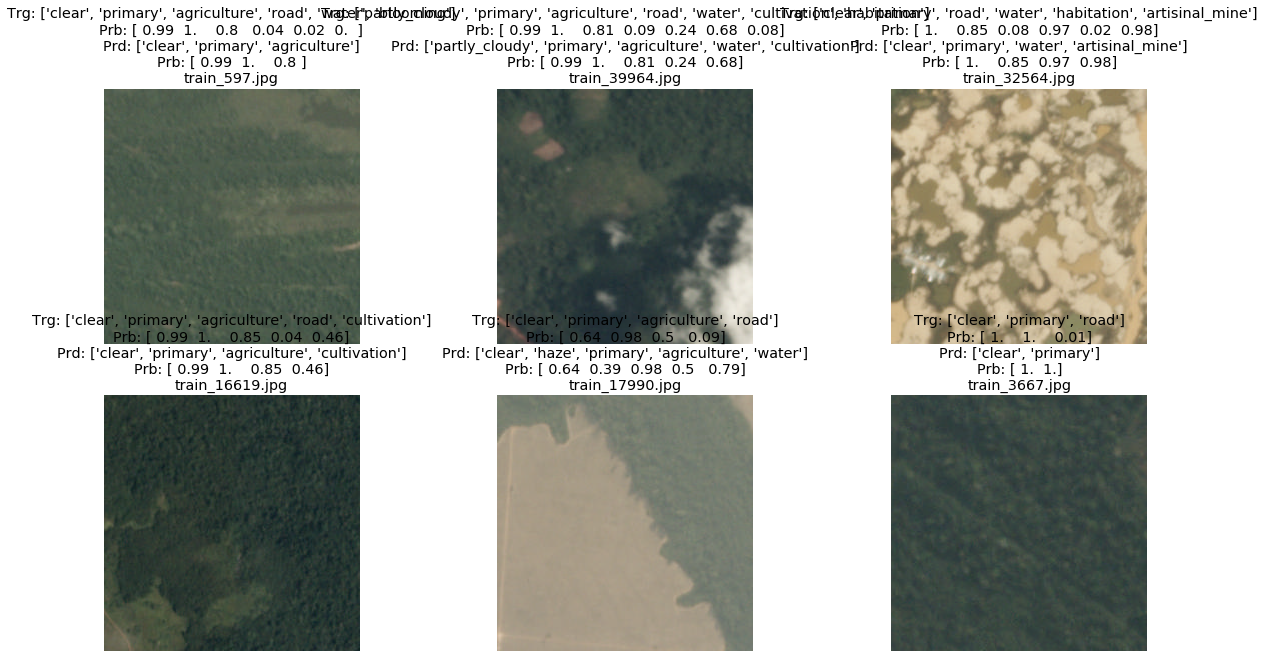

In [27]:
# View preds containing LABEL by probability

# Confident and right (TP)
confident_tp = evaluate.get_preds_by_target_and_prob(
    eval_df, LABEL, 1, p_min=0.9, p_max=1.0)
# Confident and wrong (FP)
confident_fp = evaluate.get_preds_by_target_and_prob(
    eval_df, LABEL, 0, p_min=0.9, p_max=1.0)
# Unconfident and right (TN)
unconfident_tn = evaluate.get_preds_by_target_and_prob(
    eval_df, LABEL, 0, p_min=0.0, p_max=0.1)
# Unconfident and wrong (FN)
unconfident_fn = evaluate.get_preds_by_target_and_prob(
    eval_df, LABEL, 1, p_min=0.0, p_max=0.1)

evaluate.plot_predictions(unconfident_fn, comp.LABEL_NAMES)

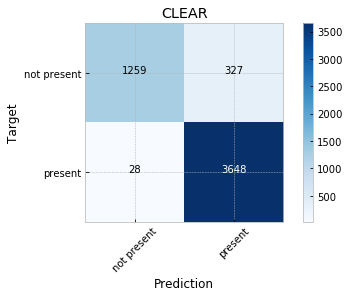

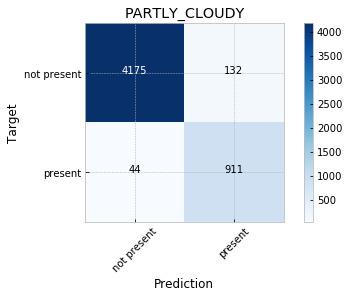

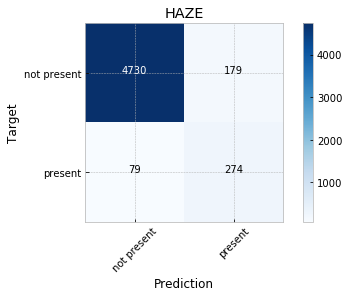

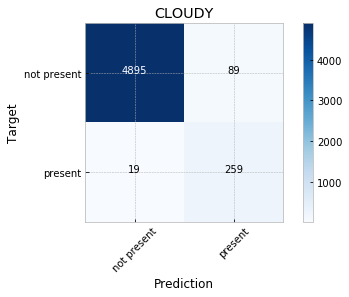

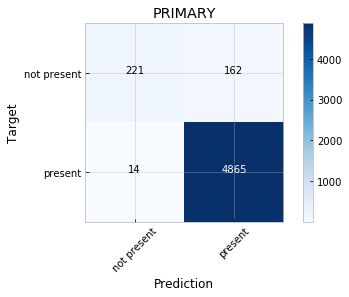

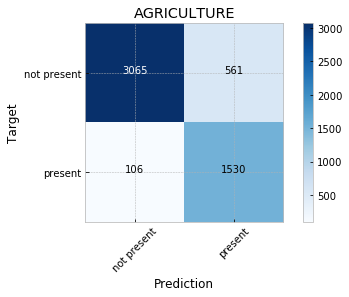

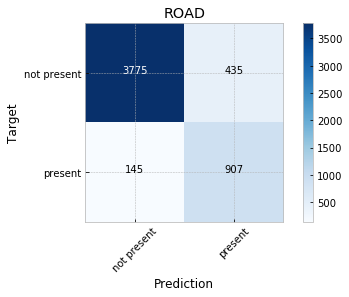

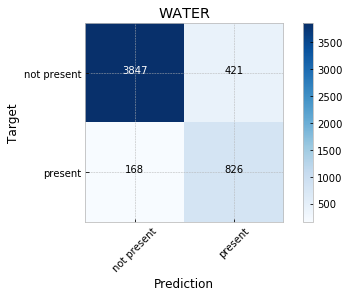

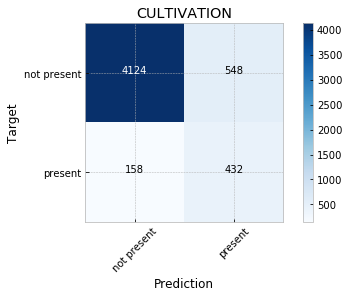

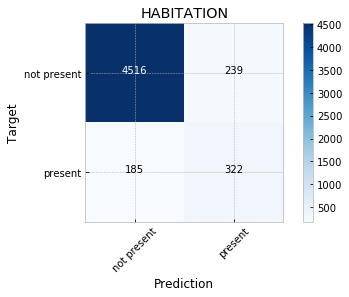

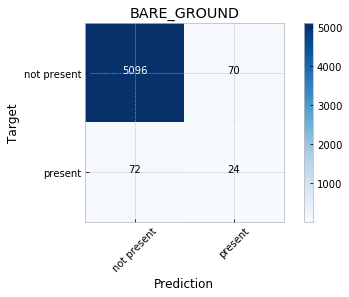

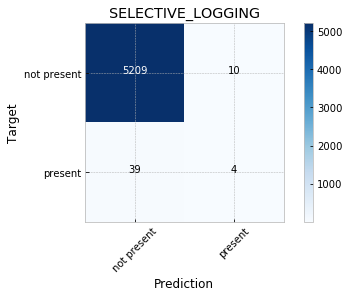

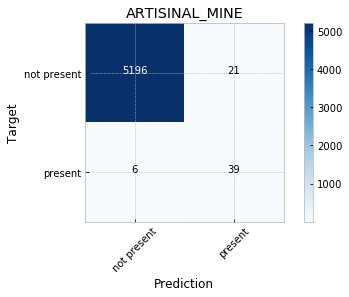

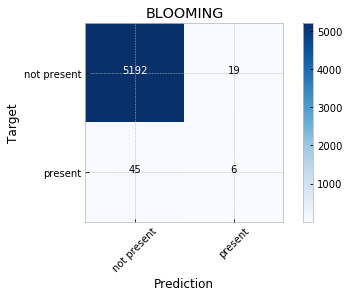

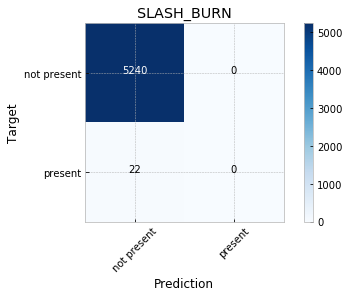

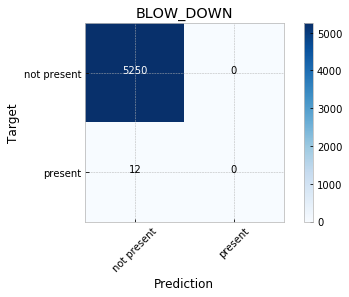

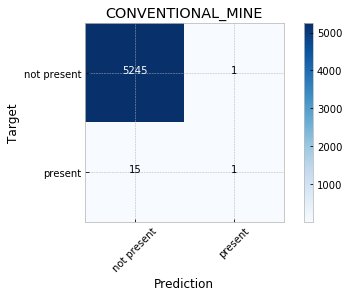

In [28]:
# Confusion Matrix
evaluate.plot_label_level_cms(eval_df, comp.LABEL_NAMES)

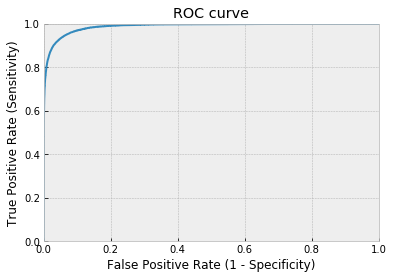

In [29]:
# Plot ROC Curve
evaluate.plot_roc_curve(np.array(probs), val_targs)